![Add a relevant banner image here](path_to_image)

# Project Title

## Overview

This project seeks to build machine learning models to achieve two things:

1. Predict the highest ranking a song will achieve on the Billboard Hot 100 list.
2. Predict the largest week over week increase in a given song's ranking on the Hot 100 list.

Key Insights:

- A song's genre has a minimal impact on its ranking on the Billboard Hot 100 list.
- Song characteristics such as tempo, danceability, etc. appear to be the strongest drivers of their performance on the Hot 100 list.
- Analyzing music can quickly lead to an overwhelming number of features, so thoughtful and careful data selection is key.

## Business Understanding

The customer of this project is FutureProduct Advisors, a consultancy that helps their customers develop innovative and new consumer products. FutureProduct’s customers are increasingly seeking help from their consultants in go-to-market activities. 

FutureProduct’s consultants can support these go-to-market activities, but the business does not have all the infrastructure needed to support it. Their biggest ask is for a tool to help them find interesting, up-and-coming music to accompany social posts and online ads for go-to-market promotions. 

**Stakeholders**

- FutureProduct Managing Director: oversees their consulting practice and is sponsoring this project.
- FutureProduct Senior Consultants: the actual users of the prospective tool. A small subset of the consultants will pilot the prototype tool.
- My consulting leadership: sponsors of this effort; will provide oversight and technical input of the project as needed.

**Primary Goals**

1.	Build a data tool that can evaluate any song in the Billboard Hot 100 list and make predictions about:
    -	The song’s position on the Hot 100 list 4 weeks in the future
    -	The song’s highest position on the list in the next 6 months
2.	Create a rubric that lists the 3 most important factors for songs’ placement on the Hot 100 list for each hear from 2000 to 2021.


## Data Understanding

Billboard Hot 100 weekly charts (Kaggle): https://www.kaggle.com/datasets/thedevastator/billboard-hot-100-audio-features

I’ve chosen this dataset because it has a direct measurement of song popularity (the Hot 100 list) and because its long history gives significant context to a song’s positioning in a given week.
The features list gives a wide range of song attributes to explore and enables me to determine what features most significantly contribute to a song’s popularity and how that changes over time.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ast
from collections import Counter

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(42)

In [2]:
df_hotlist_all = pd.read_csv('Data/Hot Stuff.csv')
df_features_all = pd.read_csv('Data/Hot 100 Audio Features.csv')

In [3]:
# exploring hotlist df
df_hotlist_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327895 entries, 0 to 327894
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   index                   327895 non-null  int64  
 1   url                     327895 non-null  object 
 2   WeekID                  327895 non-null  object 
 3   Week Position           327895 non-null  int64  
 4   Song                    327895 non-null  object 
 5   Performer               327895 non-null  object 
 6   SongID                  327895 non-null  object 
 7   Instance                327895 non-null  int64  
 8   Previous Week Position  295941 non-null  float64
 9   Peak Position           327895 non-null  int64  
 10  Weeks on Chart          327895 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 27.5+ MB


In [4]:
# exploring features df
df_features_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29503 entries, 0 to 29502
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      29503 non-null  int64  
 1   SongID                     29503 non-null  object 
 2   Performer                  29503 non-null  object 
 3   Song                       29503 non-null  object 
 4   spotify_genre              27903 non-null  object 
 5   spotify_track_id           24397 non-null  object 
 6   spotify_track_preview_url  14491 non-null  object 
 7   spotify_track_duration_ms  24397 non-null  float64
 8   spotify_track_explicit     24397 non-null  object 
 9   spotify_track_album        24391 non-null  object 
 10  danceability               24334 non-null  float64
 11  energy                     24334 non-null  float64
 12  key                        24334 non-null  float64
 13  loudness                   24334 non-null  flo

#### Exploratory Data Analysis

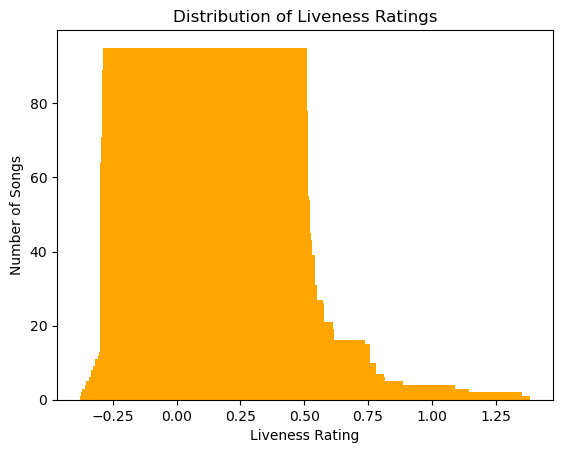

In [129]:
liveness_dist = df_cleaned_genre['liveness'].value_counts()
df_liveness_dist = pd.DataFrame(liveness_dist)
df_liveness_dist = df_liveness_dist.reset_index()

plt.bar(df_liveness_dist['liveness'], df_liveness_dist['count'], color='orange')
plt.xlabel('Liveness Rating')
plt.ylabel('Number of Songs')
plt.title('Distribution of Liveness Ratings')
plt.show()

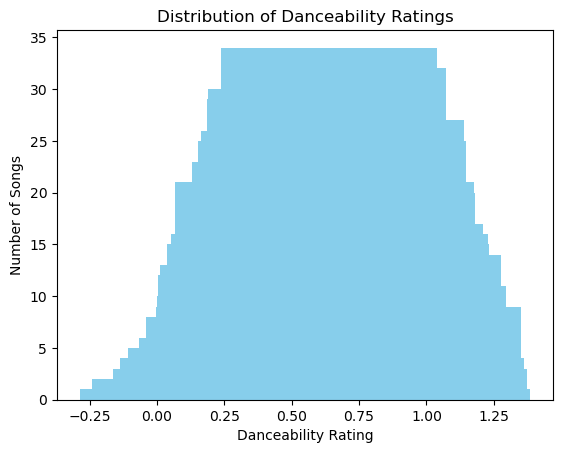

In [128]:
danceability_dist = df_cleaned_genre['danceability'].value_counts()
df_danceability_dist = pd.DataFrame(danceability_dist)
df_danceability_dist = df_danceability_dist.reset_index()

plt.bar(df_danceability_dist['danceability'], df_danceability_dist['count'], color='skyblue')
plt.xlabel('Danceability Rating')
plt.ylabel('Number of Songs')
plt.title('Distribution of Danceability Ratings')
plt.show()

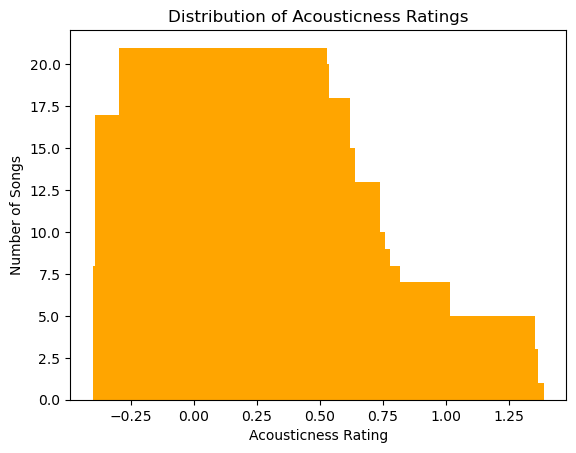

In [130]:
acousticness_dist = df_cleaned_genre['acousticness'].value_counts()
df_acousticness_dist = pd.DataFrame(acousticness_dist)
df_acousticness_dist = df_acousticness_dist.reset_index()

plt.bar(df_acousticness_dist['acousticness'], df_acousticness_dist['count'], color='orange')
plt.xlabel('Acousticness Rating')
plt.ylabel('Number of Songs')
plt.title('Distribution of Acousticness Ratings')
plt.show()

In [147]:
peak_pos_dist = df_cleaned_genre['Max_Peak_Position'].value_counts()
df_peak_pos_dist = pd.DataFrame(peak_pos_dist)
df_peak_pos_dist = df_peak_pos_dist.reset_index()
print(f"Mean Highest Ranking: {df_cleaned_genre['Max_Peak_Position'].mean():.0f}")
print(f"Standard Deviation of Highest Ranking: {df_cleaned_genre['Max_Peak_Position'].std():.1f}")

Mean Highest Ranking: 76
Standard Deviation of Highest Ranking: 24.5


Text(0.5, 1.0, 'Frequency of Peak Rankings')

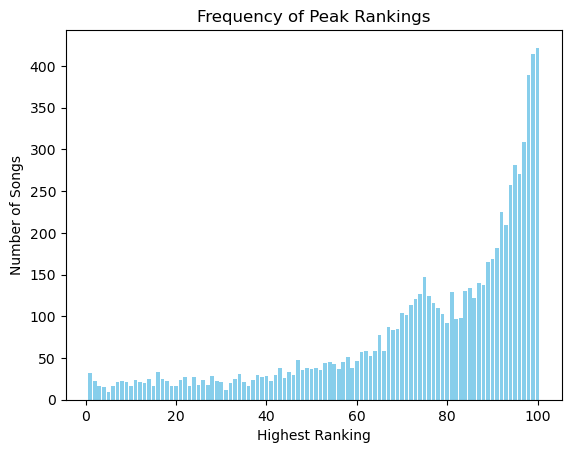

In [107]:
plt.bar(df_peak_pos_dist['Max_Peak_Position'], df_peak_pos_dist['count'], color='skyblue')
plt.xlabel('Highest Ranking')
plt.ylabel('Number of Songs')
plt.title('Frequency of Peak Rankings')

In [145]:
max_rank_change = df_cleaned_genre['Max_Rank_Change'].value_counts()
df_max_rank_change = pd.DataFrame(max_rank_change)
df_max_rank_change = df_max_rank_change.reset_index()
df_max_rank_change = df_max_rank_change[df_max_rank_change['Max_Rank_Change'] > 0]
print(f"Mean Largest Week over Week Rank Change: {df_cleaned_genre['Max_Rank_Change'].mean():.0f}")
print(f"Standard Deviation of Largest Week over Week Rank Change: {df_cleaned_genre['Max_Rank_Change'].std():.1f}")

Mean Largest Week over Week Rank Change: 13
Standard Deviation of Largest Week over Week Rank Change: 11.8


Text(0.5, 1.0, 'Frequency of Largest Week over Week Rank Change')

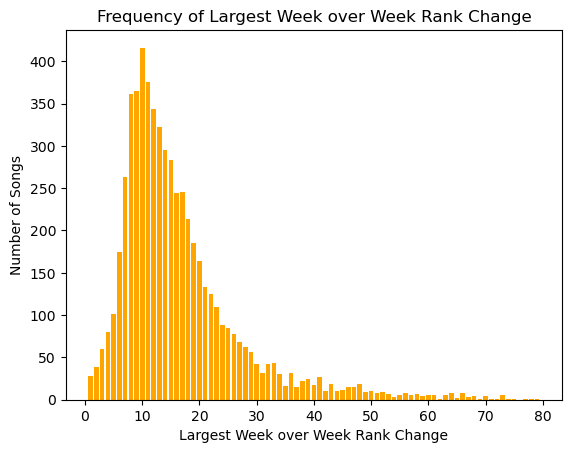

In [135]:
plt.bar(df_max_rank_change['Max_Rank_Change'], df_max_rank_change['count'], color='orange')
plt.xlabel('Largest Week over Week Rank Change')
plt.ylabel('Number of Songs')
plt.title('Frequency of Largest Week over Week Rank Change')


## Data Preparation

### Initial Data Selection and Feature Engineering

In [5]:
# removing hotlist df attributes that will not be used in cleaning or analysis
df_hotlist_all = df_hotlist_all.drop(['index', 'url', 'Song', 'Performer'], axis=1)
# converting WeekID to datetime
df_hotlist_all['WeekID'] = pd.to_datetime(df_hotlist_all['WeekID'], errors='coerce')
df_hotlist_all = df_hotlist_all.sort_values(by='WeekID')

# creating a new hotlist df with only complete year data from 2000 - 2020, the time period being studied
df_hotlist_2000s = df_hotlist_all.loc[(df_hotlist_all['WeekID'] > '1999-12-31') & (df_hotlist_all['WeekID'] < '2021-01-01')]

# adding a column to calculate the week over week change in rank
def diff(a, b):
    return a - b

df_hotlist_2000s['Rank_Change'] = df_hotlist_2000s.apply(lambda x: diff(x['Week Position'], x['Previous Week Position']), axis=1)
# replacing NaNs with 0
df_hotlist_2000s['Rank_Change'] = df_hotlist_2000s['Rank_Change'].fillna(0)

# removing features df attributes that will not be used in cleaning or analysis
df_features_all = df_features_all.drop(['index', 'Performer', 'Song', 'spotify_track_album', 
                                        'spotify_track_preview_url', 'spotify_track_explicit', 
                                        'spotify_track_popularity'], axis=1)

C:\Users\marha\AppData\Local\Temp\ipykernel_22852\797317108.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotlist_2000s['Rank_Change'] = df_hotlist_2000s.apply(lambda x: diff(x['Week Position'], x['Previous Week Position']), axis=1)
C:\Users\marha\AppData\Local\Temp\ipykernel_22852\797317108.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotlist_2000s['Rank_Change'] = df_hotlist_2000s['Rank_Change'].fillna(0)


In [6]:
# new df with the max weekly rank change for each song in df_hotlist_2000s
df_max_rank_change = df_hotlist_2000s.groupby('SongID', as_index=False)['Rank_Change'].max()
df_max_rank_change.rename(columns={'Rank_Change': 'Max_Rank_Change'}, inplace=True)
df_max_rank_change.set_index('SongID', inplace=True)

# new df with the max peak rank for each song in df_hotlist_2000s
df_max_peak_pos = df_hotlist_2000s.groupby('SongID', as_index=False)['Peak Position'].max()
df_max_peak_pos.rename(columns={'Peak Position': 'Max_Peak_Position'}, inplace=True)
df_max_peak_pos.set_index('SongID', inplace=True)

# ensuring these new dfs have no null values
df_max_rank_change['Max_Rank_Change'].isna().sum(), df_max_peak_pos['Max_Peak_Position'].isna().sum()

(0, 0)

In [7]:
# extracting full list of songs in the time period being studied
songid_list = df_hotlist_2000s['SongID'].unique()

# creating a features df with only songs in df_hotlist_2000s
df_features_2000s = df_features_all[df_features_all['SongID'].isin(songid_list)]

# checking for duplicates
print(len(df_features_2000s))
print(len(pd.unique(df_features_2000s['SongID'])))

8781
8664


In [8]:
# removing duplicates and rechecking
df_features_2000s = df_features_2000s.drop_duplicates(subset='SongID')

print(len(df_features_2000s))
print(len(pd.unique(df_features_2000s['SongID'])))

8664
8664


In [9]:
# adding max peak position to features df
df_2000s_data = df_features_2000s.join(df_max_peak_pos, on='SongID')

# adding max rank change to features df
df_2000s_data = df_2000s_data.join(df_max_rank_change, on='SongID')

# removing entries with missing values and defining as a new df
df_cleaned = df_2000s_data[df_2000s_data.notna().all(axis=1)]
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7798 entries, 5 to 29499
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SongID                     7798 non-null   object 
 1   spotify_genre              7798 non-null   object 
 2   spotify_track_id           7798 non-null   object 
 3   spotify_track_duration_ms  7798 non-null   float64
 4   danceability               7798 non-null   float64
 5   energy                     7798 non-null   float64
 6   key                        7798 non-null   float64
 7   loudness                   7798 non-null   float64
 8   mode                       7798 non-null   float64
 9   speechiness                7798 non-null   float64
 10  acousticness               7798 non-null   float64
 11  instrumentalness           7798 non-null   float64
 12  liveness                   7798 non-null   float64
 13  valence                    7798 non-null   float64
 

### Feature Engineering for Genre

The dataset has genre in a single column; the entry for each song has a variety of genres listed in that single column. In order to explore genre, I'll need to break this field out.

In [10]:
# generating a df with unique genre names
unique_genres = list(set(
    genre 
    for genre_string in df_cleaned['spotify_genre'] 
    if pd.notna(genre_string)
    for genre in ast.literal_eval(genre_string)
))

df_unique_genres = pd.DataFrame(unique_genres, columns=['genre'])

# adding counts of each unique genre name
# Extract all genres (with duplicates) and count them
all_genres_list = []
for genre_string in df_cleaned['spotify_genre']:
    if pd.notna(genre_string):
        genre_list = ast.literal_eval(genre_string)
        all_genres_list.extend(genre_list)

# Count occurrences
genre_counts = Counter(all_genres_list)

# Map counts to genres dataframe
df_unique_genres['count'] = df_unique_genres['genre'].map(genre_counts)
df_unique_genres = df_unique_genres.sort_values('count', ascending=False)

In [ ]:
# writing to csv for easier review of the data
df_unique_genres.to_csv('genre_counts.csv', index=False)

After reviewing the full set of genre counts, I created a new csv that contains genres which appear in 50 or more song entries.

In [11]:
# loading list of genres with 50 or more instances in df_cleaned
df_genres_50_up = pd.read_csv('genre_counts_50+inst.csv')

# converting df to list
final_genres_list = df_genres_50_up['genre'].tolist()

# manually one-hot encoding each genre

# creating each new genre column and initializing to 0
for genre in final_genres_list:
    df_cleaned[genre] = 0

# iterating through rows to set values to 1 when genre column appears in original spotify_genre column
for idx, genre_string in enumerate(df_cleaned['spotify_genre']):
    if pd.notna(genre_string):
        genre_list = ast.literal_eval(genre_string)
        for genre in genre_list:
            df_cleaned.at[idx, genre] = 1

C:\Users\marha\AppData\Local\Temp\ipykernel_22852\3783977166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = 0
C:\Users\marha\AppData\Local\Temp\ipykernel_22852\3783977166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[genre] = 0
C:\Users\marha\AppData\Local\Temp\ipykernel_22852\3783977166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [12]:
# reviewing full df 
pd.set_option('display.max_columns', None)
df_cleaned.head(3)

,SongID,spotify_genre,spotify_track_id,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Max_Peak_Position,Max_Rank_Change,pop,rap,pop rap,dance pop,post-teen pop,hip hop,trap,contemporary country,country road,country,southern hip hop,modern country rock,atl hip hop,r&b,canadian pop,melodic rap,urban contemporary,pop rock,hollywood,glee club,neo mellow,canadian hip hop,toronto rap,edm,gangster rap,country pop,tropical house,hip pop,modern rock,miami hip hop,latin,electropop,chicago rap,conscious hip hop,viral pop,country dawn,uk pop,dirty south rap,philly rap,detroit hip hop,alternative r&b,post-grunge,oklahoma country,talent show,canadian contemporary r&b,neo soul,boy band,reggaeton,electro house,rock,atl trap,nc hip hop,new orleans rap,emo rap,australian country,alternative metal,canadian metal,canadian rock,nu metal,alternative rock,permanent wave,dance rock,new romantic,new wave,new wave pop,soft rock,synthpop,candy pop,europop,adult standards,brill building pop,easy listening,vocal jazz,dancehall,glam metal,plugg,underground hip hop,deep pop r&b,pop punk,pittsburgh rap,acoustic pop,piano rock,art pop,canadian indie,chamber pop,indie pop,indie rock,slow core,stomp and holler,cali rap,slow game,alternative dance,dance-punk,indietronica,new rave,indie pop rap,comic,texas pop punk,bachata,latin pop,tropical,crunk,metropopolis,baton rouge rap,brooklyn drill,nyc rap,australian pop,punk,east coast hip hop,queens hip hop,west coast trap,g funk,complextro,german techno,new jack swing,escape room,indie r&b,indie soul,dmv rap,memphis hip hop,new jersey rap,british soul,danish pop,scandipop,texas country,idol,rap kreyol,dfw rap,deep southern trap,deep talent show,country rock,redneck,american folk revival,cantautor,latin arena pop,mexican pop,rock en espanol,spanish pop,country gospel,alberta country,canadian contemporary country,canadian country,emo,funk,soul,classic soul,disco,motown,post-disco,quiet storm,lilith,folk-pop,ny roots,ethiopian pop,trap queen,canadian pop punk,canadian punk,pop reggaeton,downtempo,electronic trap,shiver pop,latin hip hop,reggaeton flow,rap metal,socal pop punk,alaska indie,singer-songwriter,sertanejo,sertanejo pop,sertanejo universitario,pixie,pop emo,swedish electropop,swedish pop,garage rock,punk blues,big room,brostep,catstep,electra,funk metal,rap rock,australian dance,christian alternative rock,christian rock,canadian latin,bronx hip hop,hardcore hip hop,lounge,girl group,wrestling,west coast rap,show tunes,etherpop,indie poptimism,belgian dance,belgian pop,eurodance,progressive electro house,modern uplift,australian hip hop,kentucky hip hop,folk,mellow gold,heartland rock,art rock,experimental,experimental rock,melancholia,post-punk,psychedelic rock,jam band,barbadian pop,puerto rican pop,trap latino,deep contemporary country,lds youth,reggae fusion,progressive house,ohio hip hop,arkansas country,blues rock,modern blues rock,small room,bubblegum dance,deep big room,dutch house,smooth jazz,smooth saxophone,christian music,lgbtq+ hip hop,reggaeton colombiano,rap latina,houston rap,modern folk rock,uk americana,alternative hip hop,chicano rap,cartoon,children's music,old school hip hop,bounce,electro,disco house,canadian ccm,christian punk,indiecoustica,ectofolk,irish rock,anthem worship,ccm,christian pop,worship,bassline,social media pop,norwegian hip hop,outlaw country,hawaiian hip hop,vapor trap,bhangra,desi hip hop,desi pop,scottish singer-songwriter,grunge,hard rock,k-pop,k-pop boy group,electropowerpop,neon pop punk,trancecore,album rock,classic rock,glam rock,protopunk,north carolina hip hop,house,uk dance,nu-metalcore,trap soul,italian pop,italo dance,rock-and-roll,rockabilly,groove metal,rap conscient,drill,baroque pop,uk contemporary r&b,celtic rock,harlem hip hop,electronica,nu jazz,trip hop,bow pop,country rap,san diego rap,canadian trap,south african rock,christian indie,moombahton,neo-singer-s

I created two datasets: one containing genre and one without. This will allow me to model this data with and without genre.

In [13]:
# removing fields used for prep/cleaning but not needed for analysis
df_cleaned = df_cleaned.drop(['SongID', 'spotify_genre', 'spotify_track_id'], axis=1)

# my code added columns for all genres in spotify_genre, removing unwanted columns and creating a clean df with genre
last_col_to_keep_genre = 'emo rap'
df_cleaned_genre = df_cleaned.loc[:, :last_col_to_keep_genre]
# removing NaN rows
df_cleaned_genre = df_cleaned_genre.dropna()

# creating a clean df for analysis without genre
last_col_to_keep_no_genre = 'Max_Rank_Change'
df_cleaned_no_genre = df_cleaned.loc[:, :last_col_to_keep_no_genre]
# removing NaN rows
df_cleaned_genre = df_cleaned_genre.dropna()
df_cleaned_no_genre = df_cleaned_no_genre.dropna()

df_cleaned_genre.info(), df_cleaned_no_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7798 entries, 5 to 29499
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   spotify_track_duration_ms  7798 non-null   float64
 1   danceability               7798 non-null   float64
 2   energy                     7798 non-null   float64
 3   key                        7798 non-null   float64
 4   loudness                   7798 non-null   float64
 5   mode                       7798 non-null   float64
 6   speechiness                7798 non-null   float64
 7   acousticness               7798 non-null   float64
 8   instrumentalness           7798 non-null   float64
 9   liveness                   7798 non-null   float64
 10  valence                    7798 non-null   float64
 11  tempo                      7798 non-null   float64
 12  time_signature             7798 non-null   float64
 13  Max_Peak_Position          7798 non-null   float64
 

(None, None)

### Features and Target Variables

I'm prepping 4 versions for XGBoost and k-NN:

1. Max Peak Position, no genre (1__1 variables)
2. Max Peak Position, with genre (1_2 variables)
3. Max Rank Change, no genre (2_1 variables)
4. Max Rank Change, with genre (2_2 variables)

In [14]:
# Prepare features and target for XGBoost and k-NN max_peak_position analysis, no genre
X1_1 = df_cleaned_no_genre.drop(['Max_Peak_Position'], axis=1)
y1_1 = df_cleaned_no_genre['Max_Peak_Position']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X1_1_train, X1_1_test, y1_1_train, y1_1_test = train_test_split(X1_1, y1_1, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X1_1_train_scaled = scaler.fit_transform(X1_1_train)
X1_1_test_scaled = scaler.fit_transform(X1_1_test)

In [15]:
# Prepare features and target for XGBoost and k-NN max_peak_position analysis, including genre
X1_2 = df_cleaned_genre.drop(['Max_Peak_Position'], axis=1)
y1_2 = df_cleaned_genre['Max_Peak_Position']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X1_2_train, X1_2_test, y1_2_train, y1_2_test = train_test_split(X1_2, y1_2, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X1_2_train_scaled = scaler.fit_transform(X1_2_train)
X1_2_test_scaled = scaler.fit_transform(X1_2_test)

In [16]:
# Prepare features and target for XGBoost and k-NN max_rank_change analysis, no genre
X2_1 = df_cleaned_no_genre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y2_1 = df_cleaned_no_genre['Max_Rank_Change']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X2_1_train, X2_1_test, y2_1_train, y2_1_test = train_test_split(X2_1, y2_1, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X2_1_train_scaled = scaler.fit_transform(X2_1_train)
X2_1_test_scaled = scaler.fit_transform(X2_1_test)

In [17]:
# Prepare features and target for XGBoost and k-NN max_rank_change analysis, including genre
X2_2 = df_cleaned_genre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y2_2 = df_cleaned_genre['Max_Rank_Change']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X2_2_train, X2_2_test, y2_2_train, y2_2_test = train_test_split(X2_2, y2_2, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X2_2_train_scaled = scaler.fit_transform(X2_2_train)
X2_2_test_scaled = scaler.fit_transform(X2_2_test)

Another 4 versions of the data the deep learning model

1. Max Peak Position, no genre (3__1 variables)
2. Max Peak Position, with genre (3_2 variables)
3. Max Rank Change, no genre (4_1 variables)
4. Max Rank Change, with genre (4_2 variables)

In [18]:
# features and target for deep learning max_peak_position analysis, no genre
X3_1 = df_cleaned_no_genre.drop(['Max_Peak_Position'], axis=1)
y3_1 = df_cleaned_no_genre['Max_Peak_Position']

# Splitting the data into training and testing sets 
X3_1_train, X3_1_test, y3_1_train, y3_1_test = train_test_split(X3_1, y3_1, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X3_1_train_final, X3_1_val, y3_1_train_final, y3_1_val = train_test_split(X3_1_train, y3_1_train, test_size=0.2, random_state=42)

# normalizing 
scaler.fit(X3_1_train_final)
X3_1_train_scaled = scaler.transform(X3_1_train_final)
X3_1_val_scaled = scaler.transform(X3_1_val)
X3_1_test_scaled = scaler.transform(X3_1_test)

In [19]:
# features and target for deep learning max_peak_position analysis, including genre
X3_2 = df_cleaned_genre.drop(['Max_Peak_Position'], axis=1)
y3_2 = df_cleaned_genre['Max_Peak_Position']

# Splitting the data into training and testing sets 
X3_2_train, X3_2_test, y3_2_train, y3_2_test = train_test_split(X3_2, y3_2, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X3_2_train_final, X3_2_val, y3_2_train_final, y3_2_val = train_test_split(X3_2_train, y3_2_train, test_size=0.2, random_state=42)

# normalizing
scaler.fit(X3_2_train_final)
X3_2_train_scaled = scaler.transform(X3_2_train_final)
X3_2_val_scaled = scaler.transform(X3_2_val)
X3_2_test_scaled = scaler.transform(X3_2_test)

In [20]:
# features and target for deep learning max_rank_change analysis, no genre
X4_1 = df_cleaned_no_genre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y4_1 = df_cleaned_no_genre['Max_Rank_Change']

# Splitting the data into training and testing sets 
X4_1_train, X4_1_test, y4_1_train, y4_1_test = train_test_split(X4_1, y4_1, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X4_1_train_final, X4_1_val, y4_1_train_final, y4_1_val = train_test_split(X4_1_train, y4_1_train, test_size=0.2, random_state=42)

# normalizing
scaler.fit(X4_1_train_final)
X4_1_train_scaled = scaler.transform(X4_1_train_final)
X4_1_val_scaled = scaler.transform(X4_1_val)
X4_1_test_scaled = scaler.transform(X4_1_test)

In [21]:
# Prepare features and target for simple deep learning max_rank_change analysis, including genre
X4_2 = df_cleaned_genre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y4_2 = df_cleaned_genre['Max_Rank_Change']

# Splitting the data into training and testing sets 
X4_2_train, X4_2_test, y4_2_train, y4_2_test = train_test_split(X4_2, y4_2, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X4_2_train_final, X4_2_val, y4_2_train_final, y4_2_val = train_test_split(X4_2_train, y4_2_train, test_size=0.2, random_state=42)

# normalizing
scaler.fit(X4_2_train_final)
X4_2_train_scaled = scaler.transform(X4_2_train_final)
X4_2_val_scaled = scaler.transform(X4_2_val)
X4_2_test_scaled = scaler.transform(X4_2_test)

## Analysis

### XGBoost

**XGBoost | Max Peak Position - No Genre**

In [22]:
# XGBoost for max_peak_position, no genre

xgb_model1_1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_model1_1.fit(X1_1_train, y1_1_train)
y1_1_pred = xgb_model1_1.predict(X1_1_test)
y1_1_pred = np.clip(np.round(y1_1_pred), 1, 100)

rmse1_1 = np.sqrt(mean_squared_error(y1_1_test, y1_1_pred))
r2_1_1 = r2_score(y1_1_test, y1_1_pred)

print(f'RMSE: {rmse1_1:.3f}')
print(f'R²: {r2_1_1:.3f}')

RMSE: 24.288
R²: -0.019


In [23]:
# hyperparameter tuning 1

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb1_1 = GridSearchCV(estimator=xgb_model1_1,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb1_1.fit(X1_1_train, y1_1_train)

print("Best parameters:", grid_search_xgb1_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}


In [28]:
# hyperparameter tuning 2

param_grid2 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.15,],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

grid_search_xgb1_1 = GridSearchCV(estimator=xgb_model1_1,
                            param_grid=param_grid2,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb1_1.fit(X1_1_train, y1_1_train)

print("Best parameters:", grid_search_xgb1_1.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.75}


In [30]:
# hyperparameter tuning 3

param_grid3 = {
    'max_depth': [4, 5],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.75],
    'colsample_bytree': [0.8],
}

grid_search_xgb1_1 = GridSearchCV(estimator=xgb_model1_1,
                            param_grid=param_grid3,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb1_1.fit(X1_1_train, y1_1_train)

print("Best parameters:", grid_search_xgb1_1.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.75}


In [31]:
# Extract best/final model for max_peak_position
best_xgb1_1 = grid_search_xgb1_1.best_estimator_

# predictions
y1_1_pred_best = best_xgb1_1.predict(X1_1_test)
y1_1_pred_best = np.clip(np.round(y1_1_pred_best), 1, 100)

# Evaluate XGBoost model
rmse1_1_best = np.sqrt(mean_squared_error(y1_1_test, y1_1_pred_best))
r2_1_1_best = r2_score(y1_1_test, y1_1_pred_best)

print(f'RMSE: {rmse1_1_best:.3f}')
print(f'R²: {r2_1_1_best:.3f}')

RMSE: 22.349
R²: 0.138


**XGBoost | Max Peak Position - With Genre**

In [32]:
# XGBoost for max_peak_position, with genre

xgb_model1_2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_model1_2.fit(X1_2_train, y1_2_train)
y1_2_pred = xgb_model1_2.predict(X1_2_test)
y1_2_pred = np.clip(np.round(y1_2_pred), 1, 100)

rmse1_2 = np.sqrt(mean_squared_error(y1_2_test, y1_2_pred))
r2_1_2 = r2_score(y1_2_test, y1_2_pred)

print(f'RMSE: {rmse1_2:.3f}')
print(f'R²: {r2_1_2:.3f}')

RMSE: 24.107
R²: -0.004


In [33]:
# hyperparameter tuning 1

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb1_2 = GridSearchCV(estimator=xgb_model1_2,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb1_2.fit(X1_2_train, y1_2_train)

print("Best parameters:", grid_search_xgb1_2.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0}


In [34]:
# hyperparameter tuning 2

param_grid4 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.9, 1.0, 1.1],
    'colsample_bytree': [0.6, 0.7, 0.8],
}

grid_search_xgb1_2 = GridSearchCV(estimator=xgb_model1_2,
                            param_grid=param_grid4,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb1_2.fit(X1_2_train, y1_2_train)

print("Best parameters:", grid_search_xgb1_2.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.9}


In [35]:
# hyperparameter tuning 3

param_grid5 = {
    'max_depth': [4, 5],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.9],
    'colsample_bytree': [0.8],
}

grid_search_xgb1_2 = GridSearchCV(estimator=xgb_model1_2,
                            param_grid=param_grid5,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb1_2.fit(X1_2_train, y1_2_train)

print("Best parameters:", grid_search_xgb1_2.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.9}


In [36]:
# Extract best/final model 
best_xgb1_2 = grid_search_xgb1_2.best_estimator_

# predictions
y1_2_pred_best = best_xgb1_2.predict(X1_2_test)
y1_2_pred_best = np.clip(np.round(y1_2_pred_best), 1, 100)

# Evaluate XGBoost model
rmse1_2_best = np.sqrt(mean_squared_error(y1_2_test, y1_2_pred_best))
r2_1_2_best = r2_score(y1_2_test, y1_2_pred_best)

print(f'RMSE: {rmse1_2_best:.3f}')
print(f'R²: {r2_1_2_best:.3f}')

RMSE: 22.452
R²: 0.130


**XGBoost | Max Rank Change - No Genre**

In [37]:
# XGBoost for max_rank_change

xgb_model2_1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_model2_1.fit(X2_1_train, y2_1_train)
y2_1_pred = xgb_model2_1.predict(X2_1_test)
y2_1_pred = np.clip(np.round(y2_1_pred), 1, 100)

rmse2_1 = np.sqrt(mean_squared_error(y2_1_test, y2_1_pred))
r2_2_1 = r2_score(y2_1_test, y2_1_pred)

print(f'RMSE: {rmse2_1:.3f}')
print(f'R²: {r2_2_1:.3f}')

RMSE: 12.816
R²: -0.191


In [38]:
# hyperparameter tuning 1 for max_rank_change

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb2_1 = GridSearchCV(estimator=xgb_model2_1,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb2_1.fit(X2_1_train, y2_1_train)

print("Best parameters:", grid_search_xgb2_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}


In [39]:
# hyperparameter tuning 2 for max_rank_change

param_grid4 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.005, 0.01, 0.015],
    'subsample': [1.0, 1.1, 1.2],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

grid_search_xgb2_1 = GridSearchCV(estimator=xgb_model2_1,
                            param_grid=param_grid4,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb2_1.fit(X2_1_train, y2_1_train)

print("Best parameters:", grid_search_xgb2_1.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.005, 'max_depth': 3, 'subsample': 1.0}


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
270 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File

In [40]:
# hyperparameter tuning 3 for max_rank_change

param_grid5 = {
    'max_depth': [3],
    'learning_rate': [0.003, 0.005, 0.007],
    'subsample': [1.0],
    'colsample_bytree': [0.9],
        }

grid_search_xgb2_1 = GridSearchCV(estimator=xgb_model2_1,
                            param_grid=param_grid5,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb2_1.fit(X2_1_train, y2_1_train)

print("Best parameters:", grid_search_xgb2_1.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.005, 'max_depth': 3, 'subsample': 1.0}


In [41]:
# Extract best/final model  for max_rank_change
best_xgb2_1 = grid_search_xgb2_1.best_estimator_

y2_1_pred_best = best_xgb2_1.predict(X2_1_test)
y2_1_pred_best = np.clip(np.round(y2_1_pred_best), 1, 100)

# Evaluate XGBoost model
rmse2_1_best = np.sqrt(mean_squared_error(y2_1_test, y2_1_pred_best))
r2_2_1_best = r2_score(y2_1_test, y2_1_pred_best)

print(f'RMSE: {rmse2_1_best:.3f}')
print(f'R²: {r2_2_1_best:.3f}')

RMSE: 11.733
R²: 0.002


**XGBoost | Max Rank Change - With Genre**

In [42]:
# XGBoost for max_rank_change

xgb_model2_2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_model2_2.fit(X2_2_train, y2_2_train)
y2_2_pred = xgb_model2_2.predict(X2_2_test)
y2_2_pred = np.clip(np.round(y2_2_pred), 1, 100)

rmse2_2 = np.sqrt(mean_squared_error(y2_2_test, y2_2_pred))
r2_2_2 = r2_score(y2_2_test, y2_2_pred)

print(f'RMSE: {rmse2_2:.3f}')
print(f'R²: {r2_2_2:.3f}')

RMSE: 12.695
R²: -0.169


In [43]:
# hyperparameter tuning 1

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb2_2 = GridSearchCV(estimator=xgb_model2_2,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb2_2.fit(X2_2_train, y2_2_train)

print("Best parameters:", grid_search_xgb2_2.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}


In [44]:
# hyperparameter tuning 2

param_grid6 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.005, 0.01, 0.015],
    'subsample': [1.0, 1.1, 1.2],
    'colsample_bytree': [0.6, 0.7, 0.8],
}

grid_search_xgb2_2 = GridSearchCV(estimator=xgb_model2_2,
                            param_grid=param_grid6,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb2_2.fit(X2_2_train, y2_2_train)

print("Best parameters:", grid_search_xgb2_2.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 3, 'subsample': 1.0}


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
270 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File

In [45]:
# hyperparameter tuning 3

param_grid7 = {
    'max_depth': [3],
    'learning_rate': [0.003, 0.005, 0.007],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
}

grid_search_xgb2_2 = GridSearchCV(estimator=xgb_model2_2,
                            param_grid=param_grid7,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb2_2.fit(X2_2_train, y2_2_train)

print("Best parameters:", grid_search_xgb2_2.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.007, 'max_depth': 3, 'subsample': 1.0}


In [46]:
# Extract best/final model  for max_rank_change
best_xgb2_2 = grid_search_xgb2_2.best_estimator_

y2_2_pred_best = best_xgb2_2.predict(X2_2_test)
y2_2_pred_best = np.clip(np.round(y2_2_pred_best), 1, 100)

# Evaluate XGBoost model
rmse2_2_best = np.sqrt(mean_squared_error(y2_2_test, y2_2_pred_best))
r2_2_2_best = r2_score(y2_2_test, y2_2_pred_best)

print(f'RMSE: {rmse2_2_best:.3f}')
print(f'R²: {r2_2_2_best:.3f}')

RMSE: 11.735
R²: 0.001


#### XGBoost Summary

Using XGBoost, including the genre features slightly improved model performance. However, the Max Rank Change models both had an r<sup>2</sup> value less than 0.001, essentially indicating no fit of the model to the test data. Max Peak Position performed better, but the highest r<sup>2</sup> value was 0.138 so their predictive value is low.

Given the lack of predictive power in these outcomes, I'm shifting focus to the other two techniques.

### k-Nearest Neighbors

**k-Nearest Neighbors | Max Peak Position - No Genre**

In [47]:
# Define parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search1_1 = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search1_1.fit(X1_1_train_scaled, y1_1_train)

# Get best parameters and score
standard_best_params1_1 = grid_search1_1.best_params_
standard_best_score1_1 = grid_search1_1.best_score_
print(f"Best parameters (standard metrics): {standard_best_params1_1}")
print(f"Best cross-validation accuracy: {standard_best_score1_1:.4f}")


Starting grid search for standard metrics...
Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'distance'}
Best cross-validation accuracy: 0.0393


In [48]:
# final model with best parameters
final_model1_1 = grid_search1_1.best_estimator_

# predictions on test set
y1_1_pred = final_model1_1.predict(X1_1_test_scaled)

# Evaluate the model
accuracy1_1 = accuracy_score(y1_1_test, y1_1_pred)

print(f"Best accuracy: {accuracy1_1:.4f}")

Best accuracy: 0.0410


**k-Nearest Neighbors | Max Peak Position - With Genre**

In [49]:
# arameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search1_2 = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search1_2.fit(X1_2_train_scaled, y1_2_train)

# Get best parameters and score
standard_best_params1_2 = grid_search1_2.best_params_
standard_best_score1_2 = grid_search1_2.best_score_
print(f"Best parameters (standard metrics): {standard_best_params1_2}")
print(f"Best cross-validation accuracy: {standard_best_score1_2:.4f}")


Starting grid search for standard metrics...
Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'distance'}
Best cross-validation accuracy: 0.0381


In [50]:
# final model with best parameters
final_model1_2 = grid_search1_2.best_estimator_

# predictions on test set
y1_2_pred = final_model1_2.predict(X1_2_test_scaled)

# Evaluate the model
accuracy1_2 = accuracy_score(y1_2_test, y1_2_pred)

print(f"Best accuracy: {accuracy1_2:.4f}")

Best accuracy: 0.0523


**k-Nearest Neighbors | Max Rank Change - No Genre**

In [51]:
# Define parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search2_1 = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search2_1.fit(X2_1_train_scaled, y2_1_train)

# Get best parameters and score
standard_best_params2_1 = grid_search2_1.best_params_
standard_best_score2_1 = grid_search2_1.best_score_
print(f"Best parameters (standard metrics): {standard_best_params2_1}")
print(f"Best cross-validation accuracy: {standard_best_score2_1:.4f}")


Starting grid search for standard metrics...


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 29, 'weights': 'uniform'}
Best cross-validation accuracy: 0.2295


In [53]:
# final model with best parameters
final_model2_1 = grid_search2_1.best_estimator_


# Make predictions on test set
y2_1_pred = final_model2_1.predict(X2_1_test_scaled)


# Evaluate the model
accuracy2_1 = accuracy_score(y2_1_test, y2_1_pred)

print(f"Best accuracy: {accuracy2_1:.4f}")

Best accuracy: 0.2159


**k-Nearest Neighbors | Max Rank Change - With Genre**

In [54]:
# Define parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search2_2 = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search2_2.fit(X2_2_train_scaled, y2_2_train)

# Get best parameters and score
standard_best_params2_2 = grid_search2_2.best_params_
standard_best_score2_2 = grid_search2_2.best_score_
print(f"Best parameters (standard metrics): {standard_best_params2_2}")
print(f"Best cross-validation accuracy: {standard_best_score2_2:.4f}")


Starting grid search for standard metrics...


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 29, 'weights': 'uniform'}
Best cross-validation accuracy: 0.2320


In [55]:
# final model with best parameters
final_model2_2 = grid_search2_2.best_estimator_


# Make predictions on test set
y2_2_pred = final_model2_2.predict(X2_2_test_scaled)


# Evaluate the model
accuracy2_2 = accuracy_score(y2_2_test, y2_2_pred)

print(f"Best accuracy: {accuracy2_2:.4f}")

Best accuracy: 0.2169


#### k-NN Summary

The k-NN models performed poorly on the Max Peak Position data, with a maximum accuracy of 0.052. The performance on the Max Rank Change was better, but the maximum accuracy was still just 0.217.

I will not explore k-NN further and instead focus on the deep learning model.

### Deep Learning

**Deep Learning | Max Peak Position - No Genre**

In [56]:
# deep learning model, no regularization or dropout

baseline_model3_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X3_1_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model3_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline3_1 = baseline_model3_1.fit(
    X3_1_train_scaled, y3_1_train_final,
    validation_data=(X3_1_val_scaled, y3_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 2530.9824 - mae: 40.6783 - mse: 2530.9824 - val_loss: 797.7865 - val_mae: 21.8751 - val_mse: 797.7865
Epoch 2/100
156/156 [==============================] - 0s 1ms/step - loss: 694.9589 - mae: 21.1091 - mse: 694.9589 - val_loss: 685.6998 - val_mae: 21.0481 - val_mse: 685.6998
Epoch 3/100
156/156 [==============================] - 0s 1ms/step - loss: 638.1129 - mae: 20.1019 - mse: 638.1129 - val_loss: 656.5057 - val_mae: 19.5229 - val_mse: 656.5057
Epoch 4/100
156/156 [==============================] - 0s 1ms/step - loss: 604.6266 - mae: 19.4268 - mse: 604.6266 - val_loss: 619.3231 - val_mae: 19.2630 - val_mse: 619.3231
Epoch 5/100
156/156 [==============================] - 0s 1ms/step - loss: 585.0200 - mae: 19.0466 - mse: 585.0200 - val_loss: 604.8651 - val_mae: 19.2081 - val_mse: 604.8651
Epoch 6/100
156/156 [==============================] - 0s 1ms/step - loss: 569.3412 - mae: 18.7617 - mse: 569.3412 - val_lo

In [57]:
# deep learning model with batch normalization

bnorm_model3_1 = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X3_1_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model3_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model3_1 = bnorm_model3_1.fit(
    X3_1_train_scaled, y3_1_train_final,
    validation_data=(X3_1_val_scaled, y3_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 3ms/step - loss: 5972.7104 - mae: 73.4225 - mse: 5972.7104 - val_loss: 5671.6406 - val_mae: 71.3022 - val_mse: 5671.6406
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 4916.6826 - mae: 66.2089 - mse: 4916.6826 - val_loss: 4269.3696 - val_mae: 61.4120 - val_mse: 4269.3696
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 3552.9482 - mae: 55.6523 - mse: 3552.9482 - val_loss: 2767.3711 - val_mae: 48.9553 - val_mse: 2767.3711
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 2127.1165 - mae: 42.2377 - mse: 2127.1165 - val_loss: 1558.0217 - val_mae: 35.9289 - val_mse: 1558.0217
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 1104.1471 - mae: 29.6456 - mse: 1104.1471 - val_loss: 867.3753 - val_mae: 25.5002 - val_mse: 867.3753
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 644.2227 - mae: 21.5026 - mse: 6

In [58]:
# deep learning model regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model3_1 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X3_1_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model3_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model3_1.fit(
    X3_1_train_scaled, y3_1_train_final,
    validation_data=(X3_1_val_scaled, y3_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 2676.8977 - mae: 43.0481 - mse: 2676.8809 - val_loss: 809.7593 - val_mae: 23.3009 - val_mse: 809.7402
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 1037.4396 - mae: 26.4039 - mse: 1037.4200 - val_loss: 717.9097 - val_mae: 21.7335 - val_mse: 717.8907
Epoch 3/100
156/156 [==============================] - 0s 1ms/step - loss: 955.9871 - mae: 25.1754 - mse: 955.9683 - val_loss: 689.4614 - val_mae: 21.4177 - val_mse: 689.4425
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 892.9511 - mae: 24.4760 - mse: 892.9323 - val_loss: 647.2901 - val_mae: 20.2471 - val_mse: 647.2713
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 850.5328 - mae: 23.6285 - mse: 850.5142 - val_loss: 626.5714 - val_mae: 19.6521 - val_mse: 626.5527
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 823.8949 - mae: 23.1279 - mse: 823.8767 - val_

In [59]:
# model evaluation
print("MODEL EVALUATION: MAX PEAK POSITION, NO GENRE")

print("\n=== Baseline Model ===")
train_scores3_1 = baseline_model3_1.evaluate(X3_1_train_scaled, y3_1_train_final, verbose=0)
val_scores3_1   = baseline_model3_1.evaluate(X3_1_val_scaled, y3_1_val, verbose=0)
print(f"Train MAE: {train_scores3_1[1]:.4f}, Train MSE: {train_scores3_1[2]:.4f}")
print(f"Val   MAE: {val_scores3_1[1]:.4f}, Val   MSE: {val_scores3_1[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn3_1 = bnorm_model3_1.evaluate(X3_1_train_scaled, y3_1_train_final, verbose=0)
val_scores_bn3_1   = bnorm_model3_1.evaluate(X3_1_val_scaled, y3_1_val, verbose=0)
print(f"Train MAE: {train_scores_bn3_1[1]:.4f}, Train MSE: {train_scores_bn3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_bn3_1[1]:.4f}, Val   MSE: {val_scores_bn3_1[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg3_1 = reg_model3_1.evaluate(X3_1_train_scaled, y3_1_train_final, verbose=0)
val_scores_reg3_1   = reg_model3_1.evaluate(X3_1_val_scaled, y3_1_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")


MODEL EVALUATION: MAX PEAK POSITION, NO GENRE

=== Baseline Model ===
Train MAE: 14.9905, Train MSE: 386.6925
Val   MAE: 18.9784, Val   MSE: 620.7819

=== BatchNorm Model ===
Train MAE: 12.5579, Train MSE: 289.7504
Val   MAE: 19.5888, Val   MSE: 688.5981

=== Regularized Model (L2 + Dropout) ===
Train MAE: 16.9910, Train MSE: 482.8449
Val   MAE: 17.6678, Val   MSE: 542.0878


**Deep Learning | Max Peak Position - With Genre**

In [60]:
# deep learning model, no regularization or dropout

baseline_model3_2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X3_2_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model3_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline3_2 = baseline_model3_2.fit(
    X3_2_train_scaled, y3_2_train_final,
    validation_data=(X3_2_val_scaled, y3_2_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 3ms/step - loss: 2458.5361 - mae: 39.6388 - mse: 2458.5361 - val_loss: 635.7730 - val_mae: 19.9263 - val_mse: 635.7730
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 592.0991 - mae: 19.0866 - mse: 592.0991 - val_loss: 593.1281 - val_mae: 18.9652 - val_mse: 593.1281
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 565.4344 - mae: 18.6234 - mse: 565.4344 - val_loss: 586.8325 - val_mae: 18.6837 - val_mse: 586.8325
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 550.4894 - mae: 18.3252 - mse: 550.4894 - val_loss: 580.1015 - val_mae: 18.6102 - val_mse: 580.1015
Epoch 5/100
156/156 [==============================] - 0s 1ms/step - loss: 545.6429 - mae: 18.2447 - mse: 545.6429 - val_loss: 585.0308 - val_mae: 18.8251 - val_mse: 585.0308
Epoch 6/100
156/156 [==============================] - 0s 1ms/step - loss: 534.9498 - mae: 18.0316 - mse: 534.9498 - val_lo

In [61]:
# deep learning model with batch normalization

bnorm_model3_2 = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X3_2_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model3_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model3_2 = bnorm_model3_2.fit(
    X3_2_train_scaled, y3_2_train_final,
    validation_data=(X3_2_val_scaled, y3_2_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 3ms/step - loss: 5796.4482 - mae: 72.1152 - mse: 5796.4482 - val_loss: 5428.0703 - val_mae: 69.5475 - val_mse: 5428.0703
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 4559.3721 - mae: 63.4411 - mse: 4559.3721 - val_loss: 3782.3362 - val_mae: 57.5807 - val_mse: 3782.3362
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 3025.4043 - mae: 50.9843 - mse: 3025.4043 - val_loss: 2270.0771 - val_mae: 43.7525 - val_mse: 2270.0771
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 1642.9723 - mae: 36.6133 - mse: 1642.9723 - val_loss: 1156.4967 - val_mae: 29.8938 - val_mse: 1156.4967
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 852.7097 - mae: 25.4241 - mse: 852.7097 - val_loss: 753.6252 - val_mae: 22.7123 - val_mse: 753.6252
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 579.1253 - mae: 19.8948 - mse: 579

In [62]:
# deep learning model with regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model3_2 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X3_2_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model3_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_2 = reg_model3_2.fit(
    X3_2_train_scaled, y3_2_train_final,
    validation_data=(X3_2_val_scaled, y3_2_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 2940.8687 - mae: 45.2293 - mse: 2940.8452 - val_loss: 711.0649 - val_mae: 22.2677 - val_mse: 711.0389
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 980.9933 - mae: 25.4854 - mse: 980.9666 - val_loss: 637.2064 - val_mae: 20.7109 - val_mse: 637.1798
Epoch 3/100
156/156 [==============================] - 0s 1ms/step - loss: 919.4822 - mae: 24.7518 - mse: 919.4554 - val_loss: 618.4116 - val_mae: 20.1527 - val_mse: 618.3845
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 881.3577 - mae: 24.0350 - mse: 881.3304 - val_loss: 611.8503 - val_mae: 20.1986 - val_mse: 611.8230
Epoch 5/100
156/156 [==============================] - 0s 1ms/step - loss: 861.0094 - mae: 23.7413 - mse: 860.9818 - val_loss: 602.5735 - val_mae: 19.8850 - val_mse: 602.5458
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 815.0007 - mae: 22.9749 - mse: 814.9730 - val_lo

In [63]:
# model evaluation
print("MODEL EVALUATION: MAX PEAK POSITION, WITH GENRE")

print("\n=== Baseline Model ===")
train_scores3_2 = baseline_model3_2.evaluate(X3_2_train_scaled, y3_2_train_final, verbose=0)
val_scores3_2   = baseline_model3_2.evaluate(X3_2_val_scaled, y3_2_val, verbose=0)
print(f"Train MAE: {train_scores3_2[1]:.4f}, Train MSE: {train_scores3_2[2]:.4f}")
print(f"Val   MAE: {val_scores3_2[1]:.4f}, Val   MSE: {val_scores3_2[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn3_2 = bnorm_model3_2.evaluate(X3_2_train_scaled, y3_2_train_final, verbose=0)
val_scores_bn3_2   = bnorm_model3_2.evaluate(X3_2_val_scaled, y3_2_val, verbose=0)
print(f"Train MAE: {train_scores_bn3_2[1]:.4f}, Train MSE: {train_scores_bn3_2[2]:.4f}")
print(f"Val   MAE: {val_scores_bn3_2[1]:.4f}, Val   MSE: {val_scores_bn3_2[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg3_2 = reg_model3_2.evaluate(X3_2_train_scaled, y3_2_train_final, verbose=0)
val_scores_reg3_2   = reg_model3_2.evaluate(X3_2_val_scaled, y3_2_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_2[1]:.4f}, Train MSE: {train_scores_reg3_2[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_2[1]:.4f}, Val   MSE: {val_scores_reg3_2[2]:.4f}")


MODEL EVALUATION: MAX PEAK POSITION, WITH GENRE

=== Baseline Model ===
Train MAE: 13.0254, Train MSE: 332.5452
Val   MAE: 19.7659, Val   MSE: 703.4744

=== BatchNorm Model ===
Train MAE: 11.3073, Train MSE: 247.4965
Val   MAE: 19.4856, Val   MSE: 688.9412

=== Regularized Model (L2 + Dropout) ===
Train MAE: 17.0177, Train MSE: 473.6156
Val   MAE: 18.3192, Val   MSE: 563.2518


**Deep Learning | Max Rank Change - No Genre**

In [64]:
# deep learning model, no regularization or dropout

baseline_model4_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X4_1_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model4_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline4_1 = baseline_model4_1.fit(
    X4_1_train_scaled, y4_1_train_final,
    validation_data=(X4_1_val_scaled, y4_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 166.8389 - mae: 9.3844 - mse: 166.8389 - val_loss: 166.1515 - val_mae: 9.4419 - val_mse: 166.1515
Epoch 2/100
156/156 [==============================] - 0s 1ms/step - loss: 135.9458 - mae: 8.5229 - mse: 135.9458 - val_loss: 163.0283 - val_mae: 9.2846 - val_mse: 163.0283
Epoch 3/100
156/156 [==============================] - 0s 1ms/step - loss: 134.0581 - mae: 8.4276 - mse: 134.0581 - val_loss: 161.7386 - val_mae: 9.2282 - val_mse: 161.7386
Epoch 4/100
156/156 [==============================] - 0s 1ms/step - loss: 132.7576 - mae: 8.4219 - mse: 132.7576 - val_loss: 160.9894 - val_mae: 9.0971 - val_mse: 160.9894
Epoch 5/100
156/156 [==============================] - 0s 1ms/step - loss: 132.5367 - mae: 8.3871 - mse: 132.5367 - val_loss: 161.0836 - val_mae: 9.3114 - val_mse: 161.0836
Epoch 6/100
156/156 [==============================] - 0s 1ms/step - loss: 132.0862 - mae: 8.3657 - mse: 132.0862 - val_loss: 160.6924 

In [65]:
# deep learning model with batch normalization

bnorm_model4_1 = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X4_1_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model4_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model4_1 = bnorm_model4_1.fit(
    X4_1_train_scaled, y4_1_train_final,
    validation_data=(X4_1_val_scaled, y4_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 3ms/step - loss: 242.0373 - mae: 11.3548 - mse: 242.0373 - val_loss: 246.4373 - val_mae: 11.0393 - val_mse: 246.4373
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 160.1482 - mae: 8.9578 - mse: 160.1482 - val_loss: 178.7572 - val_mae: 9.2221 - val_mse: 178.7572
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 132.8757 - mae: 8.2646 - mse: 132.8757 - val_loss: 159.8809 - val_mae: 9.0483 - val_mse: 159.8809
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 128.3666 - mae: 8.2279 - mse: 128.3666 - val_loss: 158.2437 - val_mae: 9.0656 - val_mse: 158.2437
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 126.8588 - mae: 8.2113 - mse: 126.8588 - val_loss: 158.5294 - val_mae: 9.2304 - val_mse: 158.5294
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 126.0256 - mae: 8.2195 - mse: 126.0256 - val_loss: 158.601

In [66]:
# deep learning model with regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model4_1 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X4_1_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model4_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_1 = reg_model4_1.fit(
    X4_1_train_scaled, y4_1_train_final,
    validation_data=(X4_1_val_scaled, y4_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 174.7156 - mae: 9.6634 - mse: 174.6998 - val_loss: 168.5984 - val_mae: 9.0498 - val_mse: 168.5824
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 147.2442 - mae: 8.8319 - mse: 147.2282 - val_loss: 165.5106 - val_mae: 8.9875 - val_mse: 165.4946
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 143.2845 - mae: 8.7454 - mse: 143.2686 - val_loss: 163.0781 - val_mae: 8.9583 - val_mse: 163.0622
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 142.2874 - mae: 8.6946 - mse: 142.2715 - val_loss: 160.5559 - val_mae: 9.0276 - val_mse: 160.5401
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 142.0632 - mae: 8.7178 - mse: 142.0474 - val_loss: 163.8413 - val_mae: 8.9314 - val_mse: 163.8255
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 139.4315 - mae: 8.5952 - mse: 139.4157 - val_loss: 160.6369 

In [149]:
# model evaluation
print("MODEL EVALUATION: MAX RANK CHANGE, NO GENRE")

print("\n=== Baseline Model ===")
train_scores4_1 = baseline_model4_1.evaluate(X4_1_train_scaled, y4_1_train_final, verbose=0)
val_scores4_1   = baseline_model4_1.evaluate(X4_1_val_scaled, y4_1_val, verbose=0)
print(f"Train MAE: {train_scores4_1[1]:.4f}, Train MSE: {train_scores4_1[2]:.4f}")
print(f"Val   MAE: {val_scores4_1[1]:.4f}, Val   MSE: {val_scores4_1[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn4_1 = bnorm_model4_1.evaluate(X4_1_train_scaled, y4_1_train_final, verbose=0)
val_scores_bn4_1   = bnorm_model4_1.evaluate(X4_1_val_scaled, y4_1_val, verbose=0)
print(f"Train MAE: {train_scores_bn4_1[1]:.4f}, Train MSE: {train_scores_bn4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_bn4_1[1]:.4f}, Val   MSE: {val_scores_bn4_1[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg4_1 = reg_model4_1.evaluate(X4_1_train_scaled, y4_1_train_final, verbose=0)
val_scores_reg4_1   = reg_model4_1.evaluate(X4_1_val_scaled, y4_1_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_1[1]:.4f}, Train MSE: {train_scores_reg4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_1[1]:.4f}, Val   MSE: {val_scores_reg4_1[2]:.4f}")


MODEL EVALUATION: MAX RANK CHANGE, NO GENRE

=== Baseline Model ===
Train MAE: 5.8009, Train MSE: 58.3097
Val   MAE: 10.6579, Val   MSE: 217.1682

=== BatchNorm Model ===
Train MAE: 5.8803, Train MSE: 60.1047
Val   MAE: 10.1574, Val   MSE: 189.1355

=== Regularized Model (L2 + Dropout) ===
Train MAE: 7.4787, Train MSE: 103.1420
Val   MAE: 8.9109, Val   MSE: 159.6969


**Deep Learning | Max Rank Change - With Genre**

In [68]:
# deep learning model, no regularization or dropout

baseline_model4_2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X4_2_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model4_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline4_2 = baseline_model4_2.fit(
    X4_2_train_scaled, y4_2_train_final,
    validation_data=(X4_2_val_scaled, y4_2_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 167.2787 - mae: 9.3436 - mse: 167.2787 - val_loss: 159.3064 - val_mae: 9.0306 - val_mse: 159.3064
Epoch 2/100
156/156 [==============================] - 0s 1ms/step - loss: 133.1004 - mae: 8.3719 - mse: 133.1004 - val_loss: 160.1475 - val_mae: 9.0318 - val_mse: 160.1475
Epoch 3/100
156/156 [==============================] - 0s 1ms/step - loss: 131.0404 - mae: 8.3340 - mse: 131.0404 - val_loss: 160.2778 - val_mae: 8.9844 - val_mse: 160.2778
Epoch 4/100
156/156 [==============================] - 0s 1ms/step - loss: 129.7288 - mae: 8.2674 - mse: 129.7288 - val_loss: 159.9987 - val_mae: 9.2060 - val_mse: 159.9987
Epoch 5/100
156/156 [==============================] - 0s 1ms/step - loss: 128.5721 - mae: 8.2498 - mse: 128.5721 - val_loss: 159.5683 - val_mae: 9.0973 - val_mse: 159.5683
Epoch 6/100
156/156 [==============================] - 0s 1ms/step - loss: 127.3426 - mae: 8.2004 - mse: 127.3426 - val_loss: 162.7677 

In [69]:
# deep learning model with batch normalization

bnorm_model4_2 = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X4_2_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model4_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model4_2 = bnorm_model4_2.fit(
    X4_2_train_scaled, y4_2_train_final,
    validation_data=(X4_2_val_scaled, y4_2_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 3ms/step - loss: 240.3707 - mae: 11.3942 - mse: 240.3707 - val_loss: 237.2528 - val_mae: 10.7722 - val_mse: 237.2528
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 158.3267 - mae: 8.8901 - mse: 158.3267 - val_loss: 165.9028 - val_mae: 8.9582 - val_mse: 165.9028
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 132.7308 - mae: 8.2504 - mse: 132.7308 - val_loss: 158.1130 - val_mae: 8.9502 - val_mse: 158.1130
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 127.4978 - mae: 8.2007 - mse: 127.4978 - val_loss: 158.7803 - val_mae: 9.1574 - val_mse: 158.7803
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 127.3929 - mae: 8.2298 - mse: 127.3929 - val_loss: 160.7028 - val_mae: 9.2518 - val_mse: 160.7028
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 126.5267 - mae: 8.2148 - mse: 126.5267 - val_loss: 159.778

In [70]:
# deep learning model with regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model4_2 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X4_2_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model4_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_2 = reg_model4_2.fit(
    X4_2_train_scaled, y4_2_train_final,
    validation_data=(X4_2_val_scaled, y4_2_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 177.5023 - mae: 9.6723 - mse: 177.4815 - val_loss: 162.8854 - val_mae: 9.0157 - val_mse: 162.8637
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 145.8315 - mae: 8.8067 - mse: 145.8097 - val_loss: 162.1194 - val_mae: 8.9744 - val_mse: 162.0976
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 145.1571 - mae: 8.7987 - mse: 145.1352 - val_loss: 159.8962 - val_mae: 8.9726 - val_mse: 159.8740
Epoch 4/100
156/156 [==============================] - 0s 1ms/step - loss: 141.6491 - mae: 8.6667 - mse: 141.6270 - val_loss: 163.8217 - val_mae: 8.9538 - val_mse: 163.7997
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 140.1801 - mae: 8.6377 - mse: 140.1580 - val_loss: 160.3189 - val_mae: 8.9807 - val_mse: 160.2966
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 139.7638 - mae: 8.5965 - mse: 139.7417 - val_loss: 164.5835 

In [148]:
# model evaluation
print("MODEL EVALUATION: MAX RANK CHANGE, WITH GENRE")

print("\n=== Baseline Model ===")
train_scores4_2 = baseline_model4_2.evaluate(X4_2_train_scaled, y4_2_train_final, verbose=0)
val_scores4_2   = baseline_model4_2.evaluate(X4_2_val_scaled, y4_2_val, verbose=0)
print(f"Train MAE: {train_scores4_2[1]:.4f}, Train MSE: {train_scores4_2[2]:.4f}")
print(f"Val   MAE: {val_scores4_2[1]:.4f}, Val   MSE: {val_scores4_2[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn4_2 = bnorm_model4_2.evaluate(X4_2_train_scaled, y4_2_train_final, verbose=0)
val_scores_bn4_2   = bnorm_model4_2.evaluate(X4_2_val_scaled, y4_2_val, verbose=0)
print(f"Train MAE: {train_scores_bn4_1[1]:.4f}, Train MSE: {train_scores_bn4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_bn4_1[1]:.4f}, Val   MSE: {val_scores_bn4_1[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg4_2 = reg_model4_2.evaluate(X4_2_train_scaled, y4_2_train_final, verbose=0)
val_scores_reg4_2   = reg_model4_2.evaluate(X4_2_val_scaled, y4_2_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_2[1]:.4f}, Train MSE: {train_scores_reg4_2[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_2[1]:.4f}, Val   MSE: {val_scores_reg4_2[2]:.4f}")


MODEL EVALUATION: MAX RANK CHANGE, WITH GENRE

=== Baseline Model ===
Train MAE: 4.9412, Train MSE: 46.5678
Val   MAE: 10.7836, Val   MSE: 233.4242

=== BatchNorm Model ===
Train MAE: 5.8803, Train MSE: 60.1047
Val   MAE: 10.1574, Val   MSE: 189.1355

=== Regularized Model (L2 + Dropout) ===
Train MAE: 7.7478, Train MSE: 115.6297
Val   MAE: 9.0384, Val   MSE: 164.3925


**Deep Learning | Optimizing Regularized Models**

Max Peak Position

In [72]:
# adding a layer

l2_reg = 1e-4
dropout_rate = 0.4

reg_model3_1 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X3_1_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model3_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model3_1.fit(
    X3_1_train_scaled, y3_1_train_final,
    validation_data=(X3_1_val_scaled, y3_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 2605.2383 - mae: 42.3895 - mse: 2605.2156 - val_loss: 818.3028 - val_mae: 23.9746 - val_mse: 818.2789
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 1094.7161 - mae: 27.1154 - mse: 1094.6918 - val_loss: 753.7225 - val_mae: 23.0136 - val_mse: 753.6988
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 1025.5061 - mae: 26.3106 - mse: 1025.4824 - val_loss: 645.9583 - val_mae: 20.5030 - val_mse: 645.9342
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 951.6646 - mae: 25.1346 - mse: 951.6406 - val_loss: 694.1804 - val_mae: 22.2308 - val_mse: 694.1564
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 859.6870 - mae: 23.9276 - mse: 859.6631 - val_loss: 645.2232 - val_mae: 21.1662 - val_mse: 645.1993
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 861.2122 - mae: 23.8621 - mse: 861.1886 - va

In [73]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("    Adding an additional deep layer")
train_scores_reg3_1 = reg_model3_1.evaluate(X3_1_train_scaled, y3_1_train_final, verbose=0)
val_scores_reg3_1   = reg_model3_1.evaluate(X3_1_val_scaled, y3_1_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
    Adding an additional deep layer
Train MAE: 17.7530, Train MSE: 482.9104
Val   MAE: 18.7958, Val   MSE: 562.6985


Adding a layer resulted in a larger MAE for both training and validation. Removing the additional layer and adding kernels.

In [74]:
# adding a layer

l2_reg = 1e-4
dropout_rate = 0.4

reg_model3_1 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X3_1_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model3_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model3_1.fit(
    X3_1_train_scaled, y3_1_train_final,
    validation_data=(X3_1_val_scaled, y3_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 2043.7771 - mae: 36.2918 - mse: 2043.7443 - val_loss: 740.1660 - val_mae: 21.5077 - val_mse: 740.1331
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 862.6675 - mae: 23.7707 - mse: 862.6343 - val_loss: 665.7065 - val_mae: 20.3517 - val_mse: 665.6734
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 783.3321 - mae: 22.5739 - mse: 783.2989 - val_loss: 656.5284 - val_mae: 20.9448 - val_mse: 656.4955
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 758.4573 - mae: 22.2203 - mse: 758.4246 - val_loss: 643.0283 - val_mae: 20.7852 - val_mse: 642.9957
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 741.6042 - mae: 21.9622 - mse: 741.5714 - val_loss: 596.6270 - val_mae: 18.9125 - val_mse: 596.5941
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 717.4796 - mae: 21.4951 - mse: 717.4468 - val_lo

In [75]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("Reverting to 2 deep layers, increasing to 128 kernels per layer")
train_scores_reg3_1 = reg_model3_1.evaluate(X3_1_train_scaled, y3_1_train_final, verbose=0)
val_scores_reg3_1   = reg_model3_1.evaluate(X3_1_val_scaled, y3_1_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
Reverting to 2 deep layers, increasing to 128 kernels per layer
Train MAE: 16.6529, Train MSE: 456.7876
Val   MAE: 18.1013, Val   MSE: 555.3945


Increasing kernels per layer gave a result very similar to the original model but increased overfitting a little bit. Leaving 128 kernels per layer and increasing the dropout rate.

In [76]:
# increasing dropout rate

l2_reg = 1e-4
dropout_rate = 0.6

reg_model3_1 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X3_1_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model3_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model3_1.fit(
    X3_1_train_scaled, y3_1_train_final,
    validation_data=(X3_1_val_scaled, y3_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 2384.5278 - mae: 40.1743 - mse: 2384.4958 - val_loss: 773.5165 - val_mae: 22.5112 - val_mse: 773.4837
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 1098.0477 - mae: 27.3556 - mse: 1098.0146 - val_loss: 718.1125 - val_mae: 22.0730 - val_mse: 718.0798
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 1014.6326 - mae: 26.1078 - mse: 1014.5998 - val_loss: 676.3630 - val_mae: 21.4453 - val_mse: 676.3304
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 903.6113 - mae: 24.4630 - mse: 903.5787 - val_loss: 632.5463 - val_mae: 19.9884 - val_mse: 632.5135
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 908.5967 - mae: 24.4921 - mse: 908.5642 - val_loss: 620.4692 - val_mae: 20.0110 - val_mse: 620.4368
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 840.6660 - mae: 23.5479 - mse: 840.6335 - va

In [77]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("2 deep layers,  kernels per layer, increased dropout from 0.4 to 0.6")
train_scores_reg3_1 = reg_model3_1.evaluate(X3_1_train_scaled, y3_1_train_final, verbose=0)
val_scores_reg3_1   = reg_model3_1.evaluate(X3_1_val_scaled, y3_1_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
2 deep layers,  kernels per layer, increased dropout from 0.4 to 0.6
Train MAE: 17.3375, Train MSE: 484.7930
Val   MAE: 18.1056, Val   MSE: 547.9205


In [78]:
# adding a layer

l2_reg = 1e-4
dropout_rate = 0.6

reg_model3_1 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X3_1_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model3_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model3_1.fit(
    X3_1_train_scaled, y3_1_train_final,
    validation_data=(X3_1_val_scaled, y3_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 3ms/step - loss: 2280.0955 - mae: 39.3034 - mse: 2280.0520 - val_loss: 945.4214 - val_mae: 26.6470 - val_mse: 945.3775
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 1227.9375 - mae: 28.7019 - mse: 1227.8926 - val_loss: 871.6758 - val_mae: 25.5128 - val_mse: 871.6315
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 1076.1665 - mae: 26.9413 - mse: 1076.1224 - val_loss: 849.0858 - val_mae: 25.2917 - val_mse: 849.0414
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 1003.8463 - mae: 26.0472 - mse: 1003.8018 - val_loss: 776.9370 - val_mae: 23.9686 - val_mse: 776.8925
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 973.1307 - mae: 25.4490 - mse: 973.0862 - val_loss: 705.2618 - val_mae: 22.6258 - val_mse: 705.2171
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 906.1047 - mae: 24.4818 - mse: 906.0599 - 

In [79]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("3 deep layers, 128 kernels per layer, 0.6 dropout rate")
train_scores_reg3_1 = reg_model3_1.evaluate(X3_1_train_scaled, y3_1_train_final, verbose=0)
val_scores_reg3_1   = reg_model3_1.evaluate(X3_1_val_scaled, y3_1_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
3 deep layers, 128 kernels per layer, 0.6 dropout rate
Train MAE: 18.1621, Train MSE: 503.0637
Val   MAE: 18.8862, Val   MSE: 565.3151


The original regularized model continues to have the best MAE.

Max Rank Change

In [88]:
# adding a layer 

l2_reg = 1e-4
dropout_rate = 0.4

reg_model4_1 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X4_1_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model4_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_1 = reg_model4_1.fit(
    X4_1_train_scaled, y4_1_train_final,
    validation_data=(X4_1_val_scaled, y4_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 2ms/step - loss: 185.9329 - mae: 9.9309 - mse: 185.9113 - val_loss: 168.5940 - val_mae: 9.0832 - val_mse: 168.5720
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 150.0187 - mae: 8.9774 - mse: 149.9966 - val_loss: 170.0541 - val_mae: 9.0456 - val_mse: 170.0321
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 147.8211 - mae: 8.8369 - mse: 147.7990 - val_loss: 168.0266 - val_mae: 8.9826 - val_mse: 168.0045
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 144.7279 - mae: 8.7605 - mse: 144.7059 - val_loss: 163.3463 - val_mae: 8.9470 - val_mse: 163.3241
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 142.6960 - mae: 8.6970 - mse: 142.6739 - val_loss: 162.7365 - val_mae: 8.9233 - val_mse: 162.7144
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 140.6227 - mae: 8.6763 - mse: 140.6006 - val_loss: 166.1049 

In [89]:
print("=== Regularized Model (L2 + Dropout) ===")
print("    Adding a layer")
train_scores_reg4_1 = reg_model4_1.evaluate(X4_1_train_scaled, y4_1_train_final, verbose=0)
val_scores_reg4_1   = reg_model4_1.evaluate(X4_1_val_scaled, y4_1_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_1[1]:.4f}, Train MSE: {train_scores_reg4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_1[1]:.4f}, Val   MSE: {val_scores_reg4_1[2]:.4f}")


=== Regularized Model (L2 + Dropout) ===
    Adding a layer
Train MAE: 7.9032, Train MSE: 119.7173
Val   MAE: 8.8971, Val   MSE: 159.3540


These results are very nearly identical to the initial configurations. Doubling the kernels in each layer.

In [90]:
# adding a layer 

l2_reg = 1e-4
dropout_rate = 0.4

reg_model4_1 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X4_1_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model4_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_1 = reg_model4_1.fit(
    X4_1_train_scaled, y4_1_train_final,
    validation_data=(X4_1_val_scaled, y4_1_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
156/156 [==============================] - 1s 3ms/step - loss: 160.4022 - mae: 9.2465 - mse: 160.3602 - val_loss: 168.4850 - val_mae: 9.0377 - val_mse: 168.4428
Epoch 2/100
156/156 [==============================] - 0s 3ms/step - loss: 144.7906 - mae: 8.7934 - mse: 144.7483 - val_loss: 164.0674 - val_mae: 8.9951 - val_mse: 164.0248
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 143.3723 - mae: 8.7512 - mse: 143.3296 - val_loss: 164.8219 - val_mae: 8.9419 - val_mse: 164.7791
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 139.4269 - mae: 8.6430 - mse: 139.3838 - val_loss: 160.2244 - val_mae: 9.0327 - val_mse: 160.1812
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 138.0066 - mae: 8.5284 - mse: 137.9633 - val_loss: 166.1969 - val_mae: 8.9518 - val_mse: 166.1535
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 137.4465 - mae: 8.5308 - mse: 137.4031 - val_loss: 161.0059 

In [91]:
print("=== Regularized Model (L2 + Dropout) ===")
print("    Adding a layer")
train_scores_reg4_1 = reg_model4_1.evaluate(X4_1_train_scaled, y4_1_train_final, verbose=0)
val_scores_reg4_1   = reg_model4_1.evaluate(X4_1_val_scaled, y4_1_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_1[1]:.4f}, Train MSE: {train_scores_reg4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_1[1]:.4f}, Val   MSE: {val_scores_reg4_1[2]:.4f}")

=== Regularized Model (L2 + Dropout) ===
    Adding a layer
Train MAE: 7.4787, Train MSE: 103.1420
Val   MAE: 8.9109, Val   MSE: 159.6969


The original regularized model has the best MAE scores.

## Evaluation

### Summary of Model Performance

**XGBoost**
The XGBoost model did not return meaningful results for this dataset. The best metrics for XGBoost were:

_Maximum Peak Position_

- RMSE: 22.35
- r<sup>2</sup>: 0.138

_Maximum Rank Increase_

- RMSE: 11.73
- - r<sup>2</sup>: 0.002

**k-Nearest Neighbors**
This model also did not perform well on this data set. Its best metrics were:

_Maximum Peak Position_

- Accuracy: 0.052

_Maximum Rank Increase_

- Accuracy: 0.217

**Deep Learning**

The deep learning model returned the most promising results and are described in the next section.

### Final Models

The final models are both based on a deep learning architecture. 

_Maximum Peak Position_

The best model for the Maximum Peak Position is named reg_model3_1. It is a 3-layer, regularized model trained on the song dataset that does not contain genre information.Its final metrics were:

- Training mean absolute error: 16.99
- Validation mean absolute error: 17.67

_Maximum Rank Increase_

The best model for the Maximum Rank Increase is named reg_model4_2. It is also a 3-layer, regularized model trained on the song dataset without genre.
Its final metrics:

- Training mean absolute error: 7.75
- Validation mean absolute error: 8.91

### Business Insight/Recommendation 1

The genre of a song, at least how it is captured on Spotify, has very little influence on its movement on the Billboard Hot 100 list. This gives FutureProduct Advisors consultants and their customers significant leeway when they are selecting music for their social and advertising campaigns.

### Business Insight/Recommendation 2

The characteristics of a given song appear to be the most important factors in its performance on the Hot 100 list. Features such as tempo, danceability, etc. have the most predictive power for the Hot 100 list.

### Business Insight/Recommendation 3

Digital music has a large number of characteristics that can be pulled into machine learning models. The factors that have the largest influence on popularity are often unexpected, and modeling and analysis of songs requires methodical and careful selection and vetting of features.

## Conclusion and Next Steps

reg_model3_1 (predicting highest ranking on the Billboard Hot 100) and reg_model4_2 (predicting largest week over week ranking increase) are ready for initial deployment to FutureProduct Advisors. 

Detailed training will be provided, but at a high level here is how users will engage:

1. Consultants will identify a list of songs they'd like to explore.
    - We recommend using the songs in places 90-100 of the Billboard Hot 100 at a minimum
2. Consultants download those songs' metadata from Spotify as a CSV file (detailed instructions to come)
3. Consultants load the CSV file into these models, and the models will return predicted activity for each song.

There is also an additional opportunity to built on and refine these models by indluding additional data and experimenting with other modeling approaches. If the FutureProduct Advisors consultants have positive feedback on these prototype tools, we will be happy to partner on future enhancements.
